In [1]:
from pathlib import Path 

import albumentations.augmentations.transforms as A
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import pytorch_lightning as pl
import torchvision.utils as utils
from albumentations.core.composition import Compose
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader, Dataset

from PIL import Image

In [2]:
train = pd.read_csv('../data/train_folds.csv')
train.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID,kfold
0,1.2.826.0.1.3680043.8.498.11129277979862559057...,0,0,1,0,0,1,0,0,0,1,1,8849382d0,0
1,1.2.826.0.1.3680043.8.498.11050967545366588098...,0,0,0,0,0,0,0,0,0,1,0,6341a7664,0
2,1.2.826.0.1.3680043.8.498.12104979387919011811...,0,0,0,0,0,0,0,0,1,0,0,5169ae6e3,0
3,1.2.826.0.1.3680043.8.498.10756893264881684897...,0,0,0,0,0,0,0,0,0,1,0,eb2b8c9ae,0
4,1.2.826.0.1.3680043.8.498.73379559589406887236...,0,0,0,1,0,0,0,0,0,1,0,64f279182,0


In [3]:
target_cols = train.columns[1:-2]

## Check label distribution on training set

In [4]:
train.loc[:, target_cols].mean()

ETT - Abnormal                0.002626
ETT - Borderline              0.037829
ETT - Normal                  0.240667
NGT - Abnormal                0.009274
NGT - Borderline              0.017585
NGT - Incompletely Imaged     0.091347
NGT - Normal                  0.159459
CVC - Abnormal                0.106206
CVC - Borderline              0.281222
CVC - Normal                  0.708839
Swan Ganz Catheter Present    0.027590
dtype: float64

## Use observed frequency on training set as predictions

In [5]:
pred = train.loc[:, target_cols].mean().values
y_pred = np.tile(pred, (train.shape[0], 1))
y_pred.shape

(30083, 11)

In [6]:
y_true = train.loc[:, target_cols].values
roc_auc_score(y_true, y_pred, average="macro")

0.5

## RandomForest + ImageNet embeddings 

In [7]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, targets, augmentation):
        self.image_paths = image_paths
        self.targets = targets
        self.augmentation = augmentation
        self.length = len(image_paths)

    def __len__(self):
        return self.length

    def __getitem__(self, item):
        image = np.array(Image.open(self.image_paths[item]))

        if self.augmentation:
            image = self.augmentation(image=image)["image"]

        if self.targets is not None:
            return image, self.targets[item]
        else:
            return image

In [8]:
SZ = 128

class RazncrDataModule(pl.LightningDataModule):

    def __init__(self, data_path: Path, fold: int=None):
        super().__init__()
        self.data_path = data_path
        self.fold = fold
        self.augmentation = Compose([
            A.Resize(SZ, SZ),
            ToTensorV2()
        ])

    def prepare_data(self):
        pass

    def setup(self, stage=None):
        df = pd.read_csv(self.data_path / 'train_folds.csv')
        df_train = df[df.kfold!=self.fold]
        df_valid = df[df.kfold==self.fold]
        
        if stage == 'fit' or stage is None:
            train_image_paths = [self.data_path / f"train/{x}.jpg" for x in df_train.StudyInstanceUID.values]
            valid_image_paths = [self.data_path / f"train/{x}.jpg" for x in df_valid.StudyInstanceUID.values]
            
            train_targets = df_train.loc[:, target_cols].values
            valid_targets = df_valid.loc[:, target_cols].values
            
            self.train_ds = ImageDataset(train_image_paths, targets=train_targets, augmentation=self.augmentation)
            self.valid_ds = ImageDataset(valid_image_paths, targets=valid_targets, augmentation=self.augmentation)

#         if stage == 'test' or stage is None:
#             test_image_paths = [test_img_path / x + ".jpg" for x in df_test.StudyInstanceUID.values]

#             self.test_ds  = RanzcrDataset(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=32)

    def val_dataloader(self):
        return DataLoader(self.valid_ds, batch_size=32)

#     def test_dataloader(self):
#         return DataLoader(self.test_ds, batch_size=32)

In [9]:
dm = RazncrDataModule(data_path=Path('../data/'))
dm.setup()

In [10]:
dl = dm.train_dataloader()

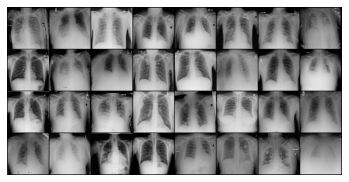

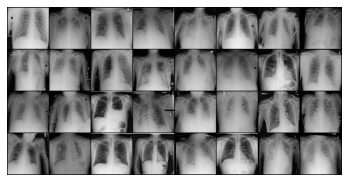

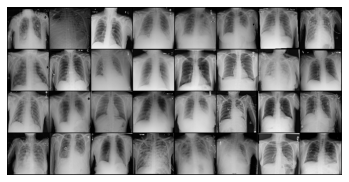

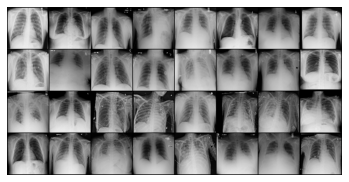

In [11]:
def plot_a_batch(dl: DataLoader):
    for batch_number, batch in enumerate(dl):
        plt.figure()
        show_images_in_batch(batch=batch, verbose=False)
        plt.axis("off")
        plt.ioff()
        plt.show()
        if batch_number == 3:
            break


def show_images_in_batch(batch, verbose=False):
    images, targets = batch
    
    if verbose:
        print(images.shape)
        print(targets)
        
    grid = utils.make_grid(images)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
plot_a_batch(dl=dl)